# Simulation of NMR CPMG experiments with ipywidgets

When **this notebook is opened**, then select in the menu, Kernel -> Restart & Run all.<br>
This is to refresh the widgets.

* [This noteboook is available at github.com/tlinnet/mybinder_relax](https://github.com/tlinnet/mybinder_relax/blob/master/CPMG_NMR_relax_interactive.ipynb)

* [The widgets can be seen at mybinder.org by clicking here](https://mybinder.org/v2/gh/tlinnet/mybinder_relax/master?filepath=CPMG_NMR_relax_interactive.ipynb)


# Jump to interactive plotting widgets

* [CR72 widget](#CR72_widget)
* ['NS CPMG 2-site expanded' widget](#NS_widget)
* [B14 widget](#B14_widget)
* [TSMFK01 widget](#TSMFK01_widget)
* [Examine Baldwin](#CR72_B14_widget)
* [Examine Rotten Banana](#banana)
* [References and links](#references)

## Import code

In [1]:
### If relax is locally installed
import os, sys, pathlib
sys.path.append( os.path.join(str(pathlib.Path.home()), "software", "relax", "lib", "dispersion" ))
try:
    import cr72
# Else download it
except ImportError:
    import urllib.request
    urllib.request.urlretrieve('https://raw.githubusercontent.com/nmr-relax/relax/master/lib/dispersion/cr72.py', 'cr72.py')
    urllib.request.urlretrieve('https://raw.githubusercontent.com/nmr-relax/relax/master/lib/dispersion/ns_cpmg_2site_expanded.py', 'ns_cpmg_2site_expanded.py')
    urllib.request.urlretrieve('https://raw.githubusercontent.com/nmr-relax/relax/master/lib/dispersion/b14.py', 'b14.py')
    urllib.request.urlretrieve('https://raw.githubusercontent.com/nmr-relax/relax/master/lib/dispersion/tsmfk01.py', 'tsmfk01.py')
# import
import cr72
import ns_cpmg_2site_expanded
import b14
import tsmfk01

# See which file is used
print("Using file: %s"% cr72.__file__ )

Using file: /home/developer/software/relax/lib/dispersion/cr72.py


In [2]:
# Import python packages
import numpy as np
# Plotting
# Set backend.
# This must be done before importing.
#%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt

# Widgets
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

## Calculate for models

Remade from http://dx.doi.org/10.1021/ja011300z

In [3]:
from IPython.display import Image
Image(url= "images/CPMG_pulse.png")

In [4]:
# Setup parameters
def cr72_calc(R20=None, dw_rad=None, pA=None, kex=None, cpmg_frqs=None):
    # For simpel model, R20A and R20B is the same
    R20A = R20B = R20
    # Make empty y_val
    y_R2 = np.zeros(cpmg_frqs.size)
    # Calculate y, and make in-memore replacement in y
    cr72.r2eff_CR72(r20a=R20A, r20a_orig=R20A, r20b=R20B, r20b_orig=R20B, 
           pA=pA, dw=dw_rad, dw_orig=dw_rad, kex=kex, 
           cpmg_frqs=cpmg_frqs, back_calc=y_R2)
    return y_R2

# Setup parameters
def ns_calc(R20=None, dw_rad=None, pA=None, kex=None, cpmg_frqs=None, relax_time=None, inv_relax_time=None, tcp=None, num_cpmg=None):
    # Make empty y_val
    y_R2 = np.zeros(cpmg_frqs.size)    
    # Calculate y, and make in-memore replacement in y
    ns_cpmg_2site_expanded.r2eff_ns_cpmg_2site_expanded(
            r20=R20, pA=pA, dw=dw_rad, dw_orig=dw_rad, kex=kex, 
            relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, 
            back_calc=y_R2, num_cpmg=num_cpmg)
    return y_R2

# Setup parameters
def b14_calc(R20=None, dw_rad=None, pA=None, kex=None, cpmg_frqs=None, relax_time=None, inv_relax_time=None, tcp=None, num_cpmg=None):
    # For simpel model, R20A and R20B is the same
    R20A = R20B = R20
    # Make empty y_val
    y_R2 = np.zeros(cpmg_frqs.size)    
    # Calculate y, and make in-memore replacement in y
    b14.r2eff_B14(r20a=R20A, r20b=R20B,
            pA=pA, dw=dw_rad, dw_orig=dw_rad, kex=kex,
            ncyc=num_cpmg, inv_tcpmg=inv_relax_time, tcp=tcp, back_calc=y_R2)
    return y_R2

def tsmfk01_calc(R20=None, dw_rad=None, kex=None, cpmg_frqs=None, tcp=None):
    # Rename parameters
    R20A = R20
    k_AB = kex
    # Make empty y_val
    y_R2 = np.zeros(cpmg_frqs.size)
    # Calculate y, and make in-memore replacement in y
    tsmfk01.r2eff_TSMFK01(r20a=R20A, dw=dw_rad, dw_orig=dw_rad, k_AB=k_AB, tcp=tcp, back_calc=y_R2)

    return y_R2

# Calc v CPMG
def calc_cpmg_frqs_linspace_cpmg(cpmg_e=None, relax_time=None):
    """
    @keyword cpmg_e:     The end value of the CPMG pulse train. In Hz.
    @keyword relax_time: The experiment specific fixed time period for relaxation (in seconds).
    """
    # Make x values. In Hz.
    # First find minimum v_cpmg. The minimum number of recycling pulses is 1.
    v_min = 1. / relax_time
    # Round up to nearest 10
    v_min = v_min + (- v_min % 10 )
    x_cpmg_frqs = np.linspace(v_min, cpmg_e, num=1000)

    # Collect power
    power_arr = []
    tau_cpmg_arr = []
    for cpmg_frq in x_cpmg_frqs:
        # num_cpmg
        power = int(round(cpmg_frq * relax_time))
        power_arr.append(power)
        # tcp
        tau_cpmg = 0.25 * relax_time / power
        tau_cpmg_arr.append(tau_cpmg)
    # Convert to numpy
    num_cpmg = np.asarray(power_arr)
    tcp = np.asarray(tau_cpmg_arr)
    return x_cpmg_frqs, num_cpmg, tcp

def calc_cpmg_frqs_tau(cpmg_e=None, relax_time=None):
    """
    @keyword cpmg_e:     The end value of the CPMG pulse train. In Hz.
    @keyword relax_time: The experiment specific fixed time period for relaxation (in seconds).
    """

    # First find the maximum number of recycling pulses
    Ncyc_max = cpmg_e * relax_time
    # Round up to nearest 1
    Ncyc_max = int(Ncyc_max + (- Ncyc_max % 1 ) )
    # Then make a range of Ncyc
    Ncyc_range = range(1, Ncyc_max+1)
    # Loop over Ncyc, and calculate
    tau_cpmg_arr = []
    cpmg_frqs_arr = []
    for Ncyc in Ncyc_range:
        # tcp. 2tcp is the time between the centers of successive 180 pulses in the CPMG sequence.
        tau_cpmg = relax_time / (4.*Ncyc)
        tau_cpmg_arr.append(tau_cpmg)
        # Calculate CPMG pulse train frequency v [Hz]
        cpmg_frq = 1. / (4.*tau_cpmg)
        cpmg_frqs_arr.append(cpmg_frq)
        # Calculate time between refocusing pulses
    # Convert to numpy
    num_cpmg = np.asarray(Ncyc_range)
    tcp = np.asarray(tau_cpmg_arr)
    x_cpmg_frqs = np.asarray(cpmg_frqs_arr)
    return x_cpmg_frqs, num_cpmg, tcp

# Calc for all models
def model_calc(model=None, cpmg_e=None, isotope=None, 
                relax_time=None, 
                w0_1H_s1=None, w0_1H_s2=None, 
                R20_s1=None, R20_s2=None, 
                dw_s1=None, dw_s2=None,
                pA_s1=None, pA_s2=None, 
                kex_s1=None, kex_s2=None):
    """
    @keyword model:      The model to analyse. 'CR72' or 'NS'.
    @keyword cpmg_e:     The end value of the CPMG pulse train. In Hz.
    @keyword isotope:    The isotope of nuclei. Either 1H, 15N or 13C.
    @keyword relax_time: The experiment specific fixed time period for relaxation (in seconds).
    @keyword w0_1H:      The spin Larmor frequencies for proton. In MHz.
    @keyword R20:        The transversal relaxation rate. In rad/s.
    @keyword dw:         The chemical shift difference between states A and B (in ppm).
    @keyword pA:         The population of state A.
    @keyword kex:        The exchange rate. In rad/s
    """
    # Gyromagnetic Ratio in [MHz/T]
    # http://bio.groups.et.byu.net/LarmourFreqCal.phtml
    g = {'1H':42.576, '15N':4.3156, '13C':10.705}
    # Magnet Field Strength [T]
    B0_s1 = w0_1H_s1 / g['1H']
    B0_s2 = w0_1H_s2 / g['1H']
    # Larmor frequency for isotope [MHz]
    w0_isotope_s1 = g[isotope]*B0_s1
    w0_isotope_s2 = g[isotope]*B0_s2
    # Convert dw in ppm to rad/s
    dw_rad_s1 = dw_s1 * w0_isotope_s1*2*np.pi
    dw_rad_s2 = dw_s2 * w0_isotope_s2*2*np.pi

    # Make x values. In Hz.
    inv_relax_time = 1.0 / relax_time
    #x_cpmg_frqs, num_cpmg, tcp = calc_cpmg_frqs_linspace_cpmg(cpmg_e=cpmg_e, relax_time=relax_time)
    x_cpmg_frqs, num_cpmg, tcp = calc_cpmg_frqs_tau(cpmg_e=cpmg_e, relax_time=relax_time)
    
    if model=='CR72':
        y_R2_s1 = cr72_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs)
        y_R2_s2 = cr72_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs)
    elif model=='NS':
        y_R2_s1 = ns_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
        y_R2_s2 = ns_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
    elif model=='B14':
        y_R2_s1 = b14_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
        y_R2_s2 = b14_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
    elif model=='TSMFK01':
        y_R2_s1 = tsmfk01_calc(R20=R20_s1, dw_rad=dw_rad_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, tcp=tcp)
        y_R2_s2 = tsmfk01_calc(R20=R20_s2, dw_rad=dw_rad_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, tcp=tcp)
    elif model=='CR72_B14':
        y_R2_s1 = cr72_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs)
        y_R2_s2 = b14_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
    elif model=='NS_B14':
        y_R2_s1 = ns_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
        y_R2_s2 = b14_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
    elif model=='CR72_TSMFK01':
        y_R2_s1 = cr72_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs)
        y_R2_s2 = tsmfk01_calc(R20=R20_s2, dw_rad=dw_rad_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, tcp=tcp)
    elif model=='NS_TSMFK01':
        y_R2_s1 = ns_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
        y_R2_s2 = tsmfk01_calc(R20=R20_s2, dw_rad=dw_rad_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, tcp=tcp)
    elif model=='B14_TSMFK01':
        y_R2_s1 = b14_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
        y_R2_s2 = tsmfk01_calc(R20=R20_s2, dw_rad=dw_rad_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, tcp=tcp)
        
    return x_cpmg_frqs, y_R2_s1, y_R2_s2, w0_isotope_s1, w0_isotope_s2

# Make a plot
def plot_calc(ax=None, model='CR72', cpmg_e=1000, isotope='15N', 
                relax_time = 0.06, 
                w0_1H_s1=750., w0_1H_s2=750., 
                R20_s1=13.9, R20_s2=13.9, 
                dw_s1=1.02, dw_s2=0.69,
                pA_s1=0.87, pA_s2=0.5, 
                kex_s1=4027., kex_s2=4061.):
    """
    @keyword ax:         The matplotlib axis to plot on.
    @keyword model:      The model to analyse. 'CR72' or 'NS'.
    @keyword cpmg_e:     The end value of the CPMG pulse train. In Hz.
    @keyword isotope:    The isotope of nuclei. Either 1H, 15N or 13C.
    @keyword relax_time: The experiment specific fixed time period for relaxation (in seconds).
    @keyword w0_1H:      The spin Larmor frequencies for proton. In MHz.
    @keyword R20:        The transversal relaxation rate. In rad/s.
    @keyword dw:         The chemical shift difference between states A and B (in ppm).
    @keyword pA:         The population of state A.
    @keyword kex:        The exchange rate. In rad/s
    """

    # Get x and y values
    x_cpmg_frqs, y_R2_s1, y_R2_s2, w0_isotope_s1, w0_isotope_s2 = model_calc(
                                        model=model, cpmg_e=cpmg_e, isotope=isotope, 
                                        relax_time=relax_time, 
                                        w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2, 
                                        R20_s1=R20_s1, R20_s2=R20_s2, 
                                        dw_s1=dw_s1, dw_s2=dw_s2,
                                        pA_s1=pA_s1, pA_s2=pA_s2, 
                                        kex_s1=kex_s1, kex_s2=kex_s2)
    
    # Make labels
    label_s1 = "sfrq=%.1f MHz\nR$_{2}^{0}$=%.1f rad/s\n$\Delta \omega$=%.1f ppm\np$_A$=%.3f \nk$_{ex}$=%.1f rad/s"%(w0_1H_s1, R20_s1, dw_s1, pA_s1, kex_s1)
    label_s2 = "sfrq=%.1f MHz\nR$_{2}^{0}$=%.1f rad/s\n$\Delta \omega$=%.1f ppm\np$_A$=%.3f \nk$_{ex}$=%.1f rad/s"%(w0_1H_s2, R20_s2, dw_s2, pA_s2, kex_s2)
    
    # Plot
    # Update if already existing
    if ax.lines:
        # Update y-data. x-data is the same.
        ax.lines[0].set_ydata(y_R2_s1)
        ax.lines[1].set_ydata(y_R2_s2)

        # Update legend
        ax.legend((ax.lines[0], ax.lines[1]), (label_s1, label_s2), loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(r"Isotope: %s with Larmor frequencies: $\omega_1$=%.1f $\omega_2$=%.1f MHz" % 
                     (isotope, w0_isotope_s1, w0_isotope_s2))
        # Set axis limits
        p_ylim_up = np.max(np.concatenate((y_R2_s1, y_R2_s2)))
        # Round up to nearest 5
        # Round up to nearest 5
        if model == 'TSMFK01':
            p_ylim_up = p_ylim_up + (- p_ylim_up % 2 )
        else:
            p_ylim_up = p_ylim_up + (- p_ylim_up % 5 )
        ax.set_ylim(0, p_ylim_up)
    # Create new plot, if not existing
    else:
        # Plot
        ax.plot(x_cpmg_frqs, y_R2_s1, '.-', label=label_s1)
        ax.plot(x_cpmg_frqs, y_R2_s2, '.-', label=label_s2)
        # Set labels
        ax.set_xlabel("CPMG pulse train frequency v [Hz]")
        ax.set_ylabel("R$_{2}$,eff rad/s")
        ax.set_title(r"Isotope: %s with Larmor frequencies: $\omega_1$=%.1f $\omega_2$=%.1f MHz" % 
                     (isotope, w0_isotope_s1, w0_isotope_s2))

        # Set axis limits
        p_ylim_up = ax.get_ylim()[-1]
        # Round up to nearest 5
        if model == 'TSMFK01':
            p_ylim_up = p_ylim_up + (- p_ylim_up % 2 )
        else:
            p_ylim_up = p_ylim_up + (- p_ylim_up % 5 )
        ax.set_ylim(0, p_ylim_up)
        # x_lim does not change
        ax.set_xlim(0, cpmg_e)

        # Put legend outside
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # Update canvas
    fig.canvas.draw()

## CR72 widget <a name="CR72_widget"></a>

When different parameters give same plot:

* http://dx.doi.org/10.1016/j.jmr.2006.01.010 or https://www.ncbi.nlm.nih.gov/pubmed/16458551

<IPython.core.display.Javascript object>


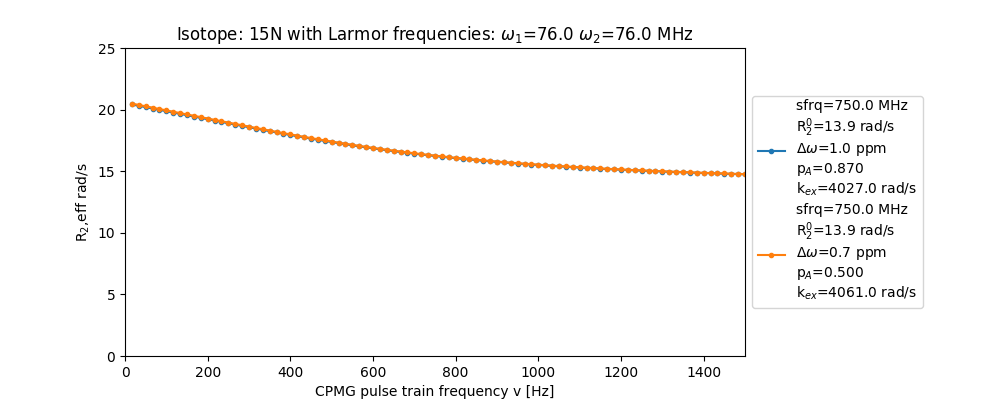

interactive(children=(FloatSlider(value=750.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=750.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=13.9, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=13.9, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=1.02, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=0.69, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.87, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.5, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=4027.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=4061.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), Output()), _dom_classes=('widget-interact',))

In [5]:
# Make figure
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_cr72 = interactive(plot_calc, ax=fixed(ax),
                       model=fixed('CR72'), cpmg_e=fixed(1500), isotope=fixed('15N'), relax_time=fixed(0.06), 
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.))
# Update fig
widget_cr72

## 'NS CPMG 2-site expanded' widget <a name="NS_widget"></a>

<IPython.core.display.Javascript object>


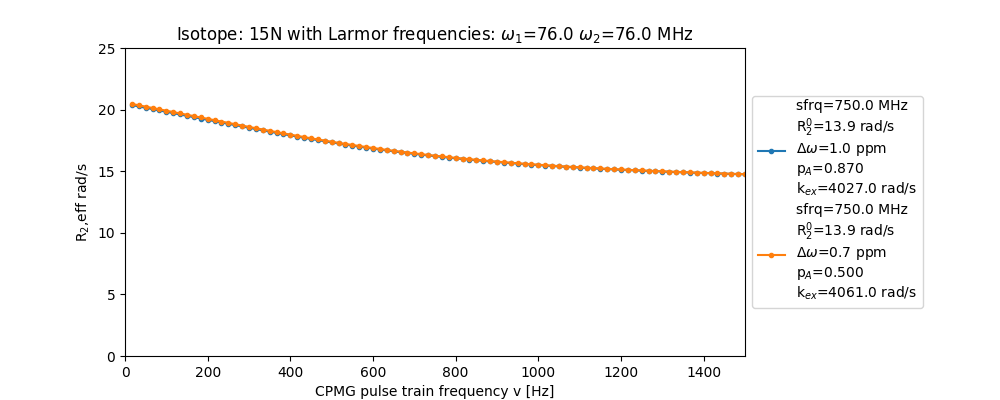

interactive(children=(FloatSlider(value=750.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=750.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=13.9, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=13.9, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=1.02, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=0.69, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.87, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.5, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=4027.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=4061.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), Output()), _dom_classes=('widget-interact',))

In [6]:
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_ns = interactive(plot_calc, ax=fixed(ax),
                       model=fixed('NS'), cpmg_e=fixed(1500), isotope=fixed('15N'), relax_time=fixed(0.06), 
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.))

widget_ns

## B14 widget <a name="B14_widget"></a>

<IPython.core.display.Javascript object>


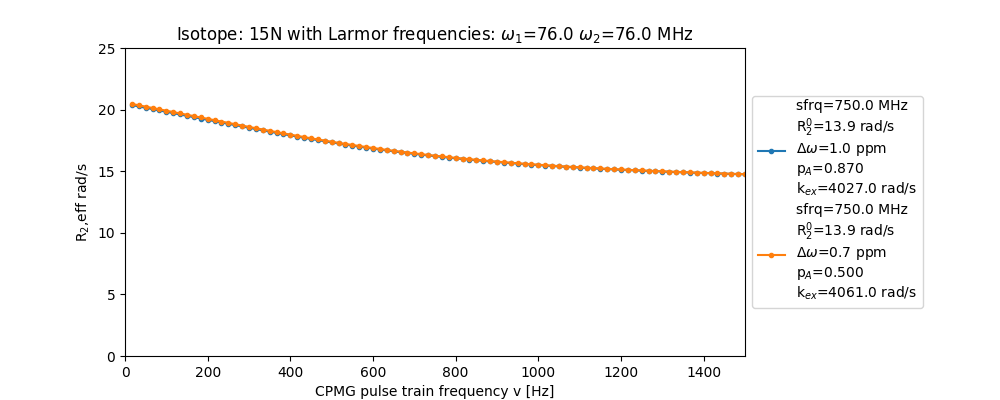

interactive(children=(FloatSlider(value=750.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=750.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=13.9, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=13.9, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=1.02, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=0.69, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.87, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.5, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=4027.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=4061.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), Output()), _dom_classes=('widget-interact',))

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_b14 = interactive(plot_calc, ax=fixed(ax),
                       model=fixed('B14'), cpmg_e=fixed(1500), isotope=fixed('15N'), relax_time=fixed(0.06), 
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.))

widget_b14

## TSMFK01 widget <a name="TSMFK01_widget"></a>
Redo Figure 3 in http://dx.doi.org/10.1021/ja011300z

<IPython.core.display.Javascript object>


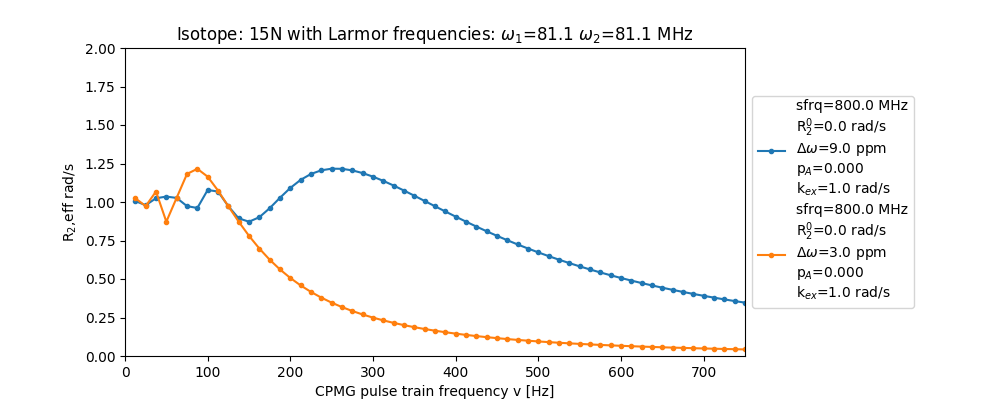

interactive(children=(FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=800.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=0.0, description='R20_s1', max=10.0, step=1.0), FloatSlider(value=0.0, description='R20_s2', max=10.0, step=1.0), FloatSlider(value=9.0, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=3.0, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=1.0, description='kex_s1', max=10.0, step=0.25), FloatSlider(value=1.0, description='kex_s2', max=10.0, step=0.25), Output()), _dom_classes=('widget-interact',))

In [8]:
# Make special plots
def plot_calc_tsmfk01(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=None,
                pA_s1=None, pA_s2=None, 
                w0_1H_s1=800., w0_1H_s2=800., 
                R20_s1=0., R20_s2=0., 
                dw_s1=9.0, dw_s2=3.0,
                kex_s1=1., kex_s2=1.):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2)

fig, ax = plt.subplots(1, figsize=(10, 4))
widget_tsmfk01 = interactive(plot_calc_tsmfk01, ax=fixed(ax),
                       model=fixed('TSMFK01'), cpmg_e=fixed(750), isotope=fixed('15N'), relax_time=fixed(0.08),
                       pA_s1=fixed(0), pA_s2=fixed(0),
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(0.0, 10.0, 1.), R20_s2=(0.0, 10.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       kex_s1=(0., 10, 0.25), kex_s2=(0., 10, 0.25))

widget_tsmfk01

Redo Figure 5 in http://dx.doi.org/10.1021/ja011300z

<IPython.core.display.Javascript object>


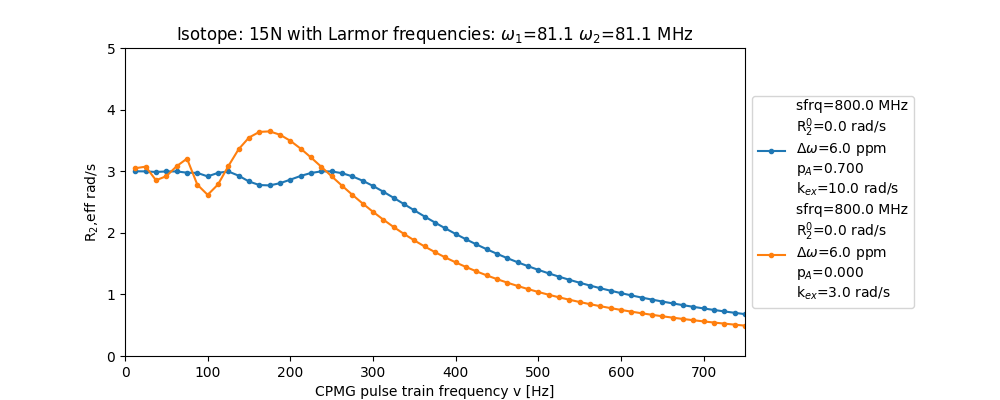

interactive(children=(FloatSlider(value=0.7, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=800.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=0.0, description='R20_s1', max=10.0, step=1.0), FloatSlider(value=0.0, description='R20_s2', max=10.0, step=1.0), FloatSlider(value=6.0, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=6.0, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=10.0, description='kex_s1', max=10.0, step=0.25), FloatSlider(value=3.0, description='kex_s2', max=10.0, step=0.25), Output()), _dom_classes=('widget-interact',))

In [9]:
# Get info from figure
tex = 0.100 # 100 ms
kex = 1./tex
pB = 0.3
pA = 1.0 - pB
k_AB = pB * kex

# Make special plots
def plot_calc_tsmfk01_2(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=None,
                pA_s1=1.0-0.3, pA_s2=None, 
                w0_1H_s1=800., w0_1H_s2=800., 
                R20_s1=0., R20_s2=0., 
                dw_s1=6.0, dw_s2=6.0,
                kex_s1=1./0.1, kex_s2=0.3*(1./0.1)):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2)

fig, ax = plt.subplots(1, figsize=(10, 4))
widget_tsmfk01_2 = interactive(plot_calc_tsmfk01_2, ax=fixed(ax),
                       model=fixed('CR72_TSMFK01'), cpmg_e=fixed(750), isotope=fixed('15N'), relax_time=fixed(0.08),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=fixed(0),
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(0.0, 10.0, 1.), R20_s2=(0.0, 10.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       kex_s1=(0., 10, 0.25), kex_s2=(0., 10, 0.25))

widget_tsmfk01_2

Compare to B14

<IPython.core.display.Javascript object>


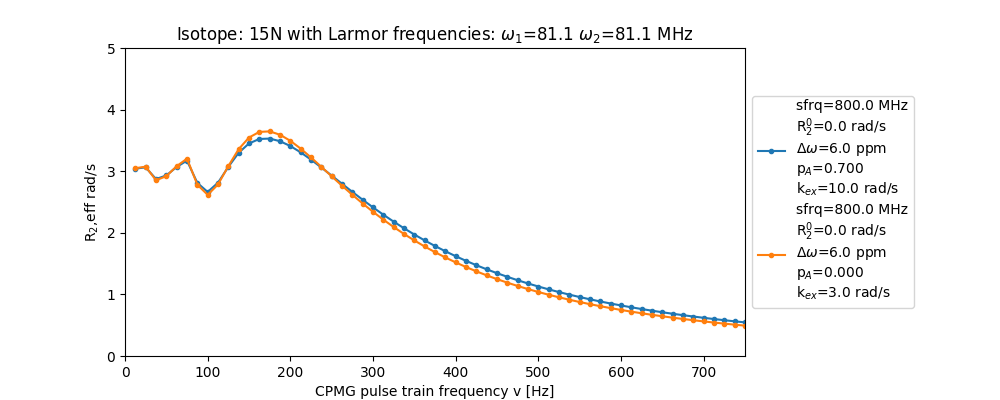

interactive(children=(FloatSlider(value=0.7, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=800.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=0.0, description='R20_s1', max=10.0, step=1.0), FloatSlider(value=0.0, description='R20_s2', max=10.0, step=1.0), FloatSlider(value=6.0, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=6.0, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=10.0, description='kex_s1', max=10.0, step=0.25), FloatSlider(value=3.0, description='kex_s2', max=10.0, step=0.25), Output()), _dom_classes=('widget-interact',))

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_tsmfk01_3 = interactive(plot_calc_tsmfk01_2, ax=fixed(ax),
                       model=fixed('B14_TSMFK01'), cpmg_e=fixed(750), isotope=fixed('15N'), relax_time=fixed(0.08),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=fixed(0),
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(0.0, 10.0, 1.), R20_s2=(0.0, 10.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       kex_s1=(0., 10, 0.25), kex_s2=(0., 10, 0.25))

widget_tsmfk01_3

## CR72 B14 & NS B15 widget <a name="CR72_B14_widget"></a>
Difference between the two models. See [A. Baldwin 2014, Fig. 1](http://dx.doi.org/10.1016/j.jmr.2014.02.023)

Analyse the number of recycling pulses, to explain the step-wise graph

<IPython.core.display.Javascript object>


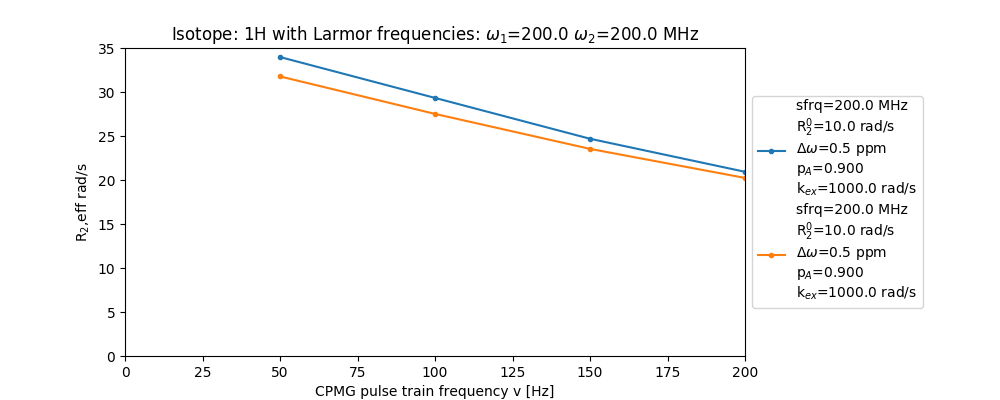

interactive(children=(FloatSlider(value=200.0, description='w0_1H_s1', max=1000.0, min=200.0, step=50.0), FloatSlider(value=200.0, description='w0_1H_s2', max=1000.0, min=200.0, step=50.0), FloatSlider(value=10.0, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=10.0, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=0.5, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=0.5, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.9, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.9, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=1000.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=1000.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), Output()), _dom_classes=('widget-interact',))

In [11]:
def plot_calc_baldwin(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=None, 
                w0_1H_s1=200., w0_1H_s2=200., 
                R20_s1=10., R20_s2=10., 
                dw_s1=0.5, dw_s2=0.5,
                pA_s1=0.90, pA_s2=0.90, 
                kex_s1=1000., kex_s2=1000.):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2)

# Make figure
fig, ax = plt.subplots(1, figsize=(10, 4))

# Make widget
widget_cr72_b14 = interactive(plot_calc_baldwin, ax=fixed(ax),
                       model=fixed('CR72_B14'), cpmg_e=fixed(200), isotope=fixed('1H'), relax_time=fixed(0.02), 
                       w0_1H_s1=(200., 1000., 50), w0_1H_s2=(200., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.))

widget_cr72_b14

Check that numerical solution NS is equal to Baldwin analytical

<IPython.core.display.Javascript object>


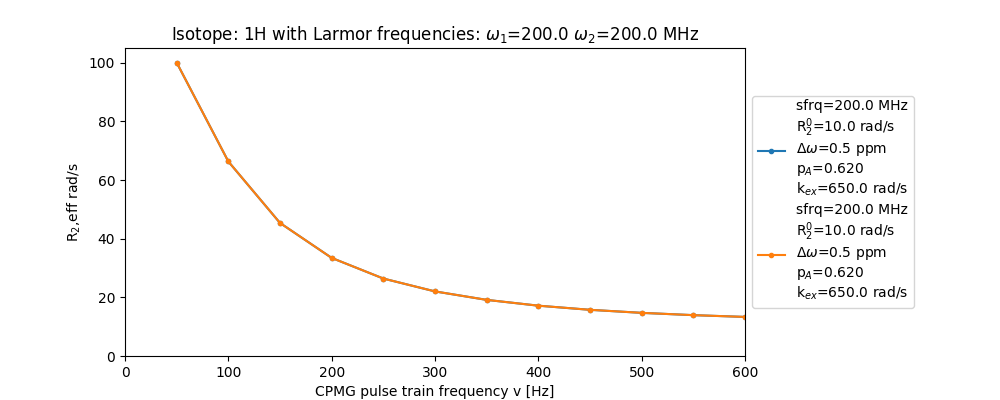

interactive(children=(FloatSlider(value=200.0, description='w0_1H_s1', max=1000.0, min=200.0, step=50.0), FloatSlider(value=200.0, description='w0_1H_s2', max=1000.0, min=200.0, step=50.0), FloatSlider(value=10.0, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=10.0, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=0.5, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=0.5, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.62, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.62, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=650.0, description='kex_s1', max=1000.0, min=400.0, step=50.0), FloatSlider(value=650.0, description='kex_s2', max=1000.0, min=400.0, step=50.0), Output()), _dom_classes=('widget-interact',))

In [12]:
def plot_calc_baldwin2(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=None, 
                w0_1H_s1=200., w0_1H_s2=200., 
                R20_s1=10., R20_s2=10., 
                dw_s1=0.5, dw_s2=0.5,
                pA_s1=0.62, pA_s2=0.62, 
                kex_s1=650., kex_s2=650.):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2)

fig, ax = plt.subplots(1, figsize=(10, 4))
widget_ns_b14 = interactive(plot_calc_baldwin2, ax=fixed(ax),
                       model=fixed('NS_B14'), cpmg_e=fixed(600), isotope=fixed('1H'), relax_time=fixed(0.02), 
                       w0_1H_s1=(200., 1000., 50), w0_1H_s2=(200., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 1000, 50.), kex_s2=(400., 1000, 50.))

widget_ns_b14

Redo Fig. 1 in Baldwin.

kex=630.0, pE=40.0, pA=0.60, R2eff=67.8, i=16, j=24
kex=816.2, pE=40.0, pA=0.60, R2eff=67.4, i=17, j=24


<IPython.core.display.Javascript object>


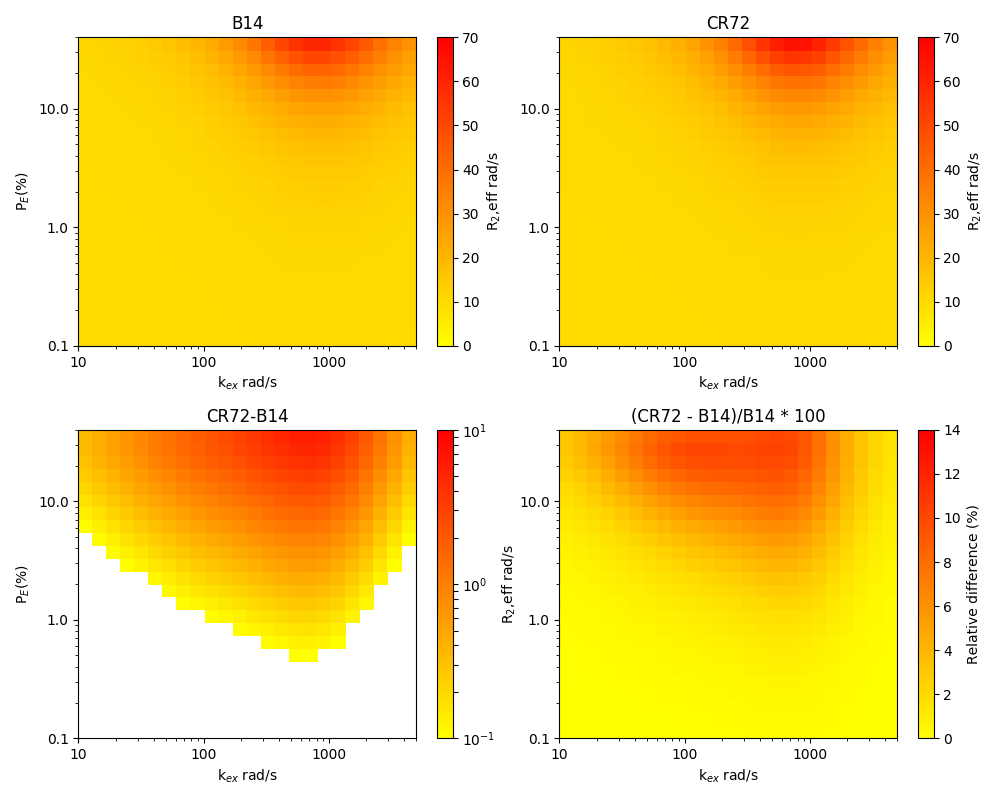

In [13]:
# Determine if to use logspace
logspace = True
num=25
if logspace:
    kex_range = np.logspace(np.log10(10), np.log10(5000), num=num)
    pE_range = np.logspace(np.log10(0.1), np.log10(40), num=num)
else:
    kex_range = np.linspace(10, 5000, num=num)
    pE_range = np.linspace(0.1, 40, num=num)

# Make meshgrid
X,Y = np.meshgrid(kex_range, pE_range, indexing='xy')
# Calculate Z
Z_CR72 = np.zeros(X.shape)
Z_B14 = np.zeros(X.shape)

# Get shape of matrix
# Loop over x. The columns
for i in range(len(kex_range)):
    # Loop over y. The rows
    for j in range(len(pE_range)):
        # Get value, by row/column indexing
        kex=X[j][i]
        # Get population of excited state
        pE=Y[j][i]
        # Calculate for pA
        pA=1.0 - pE/100.
        x_cpmg_frqs, y_CR72, y_B14, w0_isotope_s1, w0_isotope_s2 = model_calc(
                                        model='CR72_B14', cpmg_e=100., isotope='1H', relax_time=0.02, 
                                        w0_1H_s1=200., w0_1H_s2=200., R20_s1=10., R20_s2=10., 
                                        dw_s1=0.5, dw_s2=0.5, pA_s1=pA, pA_s2=pA, 
                                        kex_s1=kex, kex_s2=kex)
        # Fill value
        Z_CR72[j][i] = y_CR72[-1]
        Z_B14[j][i] = y_B14[-1]
        # Test
        if y_B14[-1] > 65.0:
            print("kex=%.1f, pE=%.1f, pA=%.2f, R2eff=%.1f, i=%i, j=%i"% (kex, pE, pA, y_B14[-1], i, j))

# Figure
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax1, ax2),(ax3, ax4) = axes

# Plot for B14
im1 = ax1.pcolormesh(kex_range, pE_range, Z_B14, cmap='autumn_r', vmin=0, vmax=70)
# Plot for CR72
im2 = ax2.pcolormesh(kex_range, pE_range, Z_CR72, cmap='autumn_r', vmin=0, vmax=70)
# Plot for CR72 - B14
Z3 = Z_CR72-Z_B14
# Fill with nan to make white
Z3[Z3 < 0.1] = np.nan
import matplotlib.colors as colors
im3 = ax3.pcolormesh(kex_range, pE_range, Z3, cmap='autumn_r', norm=colors.LogNorm(vmin=0.1, vmax=10) )
# Plot for (CR72 - B14)/B14 * 100
Z4 = (Z_CR72 - Z_B14)/Z_B14 * 100
im4 = ax4.pcolormesh(kex_range, pE_range, Z4, cmap='autumn_r', vmin=0, vmax=14)

# Set label
ax1.set_title("B14")
ax2.set_title("CR72")
ax3.set_title("CR72-B14")
ax4.set_title("(CR72 - B14)/B14 * 100")
ax1.set_xlabel("k$_{ex}$ rad/s")
ax2.set_xlabel("k$_{ex}$ rad/s")
ax3.set_xlabel("k$_{ex}$ rad/s")
ax4.set_xlabel("k$_{ex}$ rad/s")
ax1.set_ylabel("P$_E$(%)")
ax3.set_ylabel("P$_E$(%)")

# If log scale
if logspace:
    from matplotlib.ticker import ScalarFormatter
    # Loop over axes
    for ax in axes.ravel():
        # x
        ax.set_xscale('log') 
        ax.xaxis.set_major_formatter(ScalarFormatter())
        # y
        ax.set_yscale('log') 
        ax.yaxis.set_major_formatter(ScalarFormatter())
    
# Adjust layout
plt.tight_layout()
    
# Add colorbar
#plt.colorbar(im1, ax=[ax1, ax2], label="R$_{2}$,eff rad/s")
plt.colorbar(im1, ax=[ax1], label="R$_{2}$,eff rad/s")
plt.colorbar(im2, ax=[ax2], label="R$_{2}$,eff rad/s")
plt.colorbar(im3, ax=[ax3], label="R$_{2}$,eff rad/s")
plt.colorbar(im4, ax=[ax4], label="Relative difference (%)")

## Rotten banana widget <a name="banana"></a>
Examine minimization problems. See [Evgenii L. Kovrigin 1997, Fig. 2 and Fig. 5.](http://dx.doi.org/10.1016/j.jmr.2006.01.010)



sfrq: 1H: 800.0000 MHz, B0: 18.8 T, 15N 81.09 MHz
dw_1: 15N 2.944 ppm
dw_2: 15N 1.635 ppm


<IPython.core.display.Javascript object>


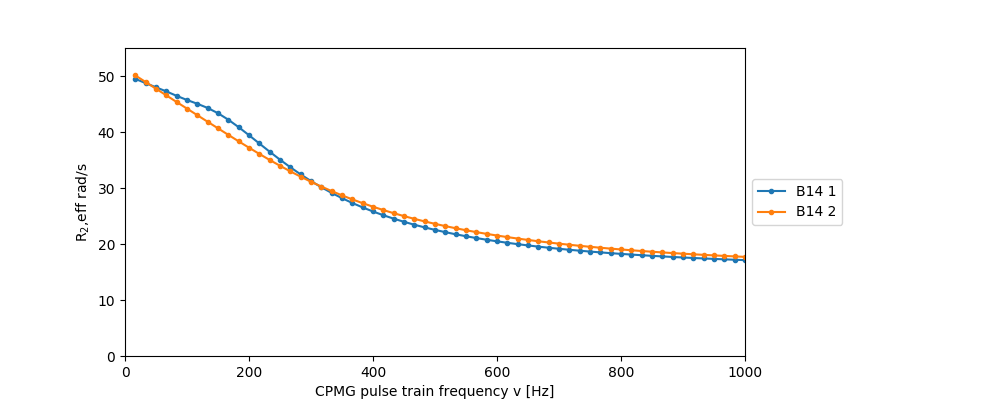

In [18]:
# From fig 1
kex_1 = 1000. # rad/s
kex_2 = 1875. # rad/s
dw_rad_1 = 1500. # rad/s
dw_rad_2 = 833. # rad/s
pA_1 = 0.95
pA_2 = 0.875
R20 = 15. # rad/s

# 
w0_1H = 800. # MHz
g = {'1H':42.576, '15N':4.3156, '13C':10.705}
B0 = w0_1H / g['1H']
# Larmor frequency for isotope [MHz]
w0_15N = g['15N']*B0
print("sfrq: 1H: %.4f MHz, B0: %.1f T, 15N %.2f MHz" % (w0_1H, B0, w0_15N))
# Convert dw in rad/s to ppm
dw_15N_1= dw_rad_1 / (w0_15N*2*np.pi)
dw_15N_2= dw_rad_2 / (w0_15N*2*np.pi)
print("dw_1: 15N %.3f ppm" % dw_15N_1)
print("dw_2: 15N %.3f ppm" % dw_15N_2)

if True:
    # Make range of CPMG
    relax_time = 0.06
    inv_relax_time = 1.0 / relax_time
    x_cpmg_frqs, num_cpmg, tcp = calc_cpmg_frqs_tau(cpmg_e=1000, relax_time=relax_time)

    # Get y
    y_R2_b14_1 = b14_calc(R20=R20, dw_rad=dw_rad_1, pA=pA_1, kex=kex_1, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
    y_R2_b14_2 = b14_calc(R20=R20, dw_rad=dw_rad_2, pA=pA_2, kex=kex_2, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)

    # Make figure
    fig, ax = plt.subplots(1, figsize=(10, 4))
    ax.plot(x_cpmg_frqs, y_R2_b14_1, '.-', label="B14 1")
    ax.plot(x_cpmg_frqs, y_R2_b14_2, '.-', label="B14 2")
    #ax.set_xlabel("$\\tau_{CP}$ [ms]")
    ax.set_xlabel("CPMG pulse train frequency v [Hz]")
    ax.set_ylabel("R$_{2}$,eff rad/s")
    ax.legend(loc='upper right')
    ax.set_title("")
    ax.set_ylim(0, 55)
    # x_lim does not change
    ax.set_xlim(0, x_cpmg_frqs[-1])
    # Put legend outside
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<IPython.core.display.Javascript object>


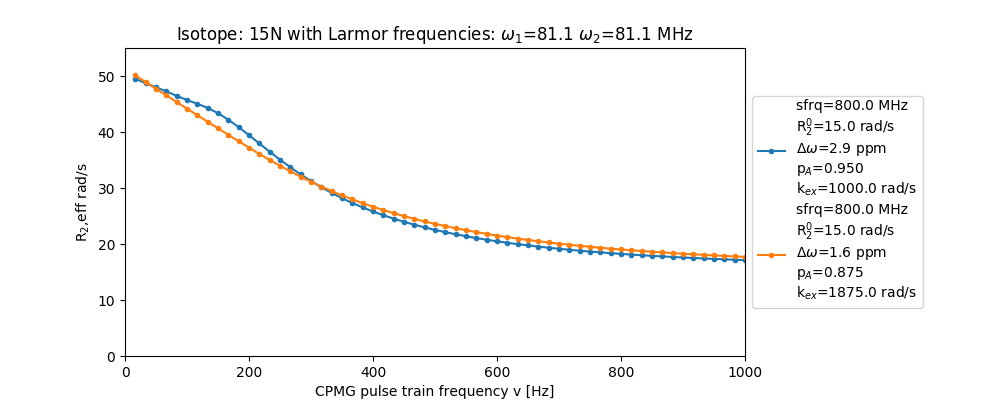

interactive(children=(FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=200.0, step=50.0), FloatSlider(value=800.0, description='w0_1H_s2', max=1000.0, min=200.0, step=50.0), FloatSlider(value=15.0, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=15.0, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=2.944, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=1.635, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.95, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.875, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=1000.0, description='kex_s1', max=5000.0, min=400.0, step=200.0), FloatSlider(value=1875.0, description='kex_s2', max=5000.0, min=400.0, step=200.0), Output()), _dom_classes=('widget-interact',))

In [15]:
def plot_calc_banana(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=None, 
                w0_1H_s1=800.0, w0_1H_s2=800.0, 
                R20_s1=15., R20_s2=15., 
                dw_s1=2.944, dw_s2=1.635,
                pA_s1=0.95, pA_s2=0.875, 
                kex_s1=1000., kex_s2=1875.):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2)

# Make figure
fig, ax = plt.subplots(1, figsize=(10, 4))

# Make widget
widget_banana = interactive(plot_calc_banana, ax=fixed(ax),
                       model=fixed('B14'), cpmg_e=fixed(1000), isotope=fixed('15N'), relax_time=fixed(0.06), 
                       w0_1H_s1=(200., 1000., 50), w0_1H_s2=(200., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 5000, 200.), kex_s2=(400., 5000, 200.))

widget_banana

In [19]:
# Make range of CPMG
relax_time = 0.06
inv_relax_time = 1.0 / relax_time
x_cpmg_frqs, num_cpmg, tcp = calc_cpmg_frqs_tau(cpmg_e=1000, relax_time=relax_time)
# Set compare value
R20_c = 15.*np.ones(x_cpmg_frqs.shape) # rad/s
kex_c = 1000. # rad/s
pA_c = 0.95
dw_rad_c_1 = 1500 # rad/s
# Set sfrq
w0_1H_1 = 800. # MHz
g = {'1H':42.576, '15N':4.3156, '13C':10.705}
B0_1 = w0_1H_1 / g['1H']
# Calculate dw in ppm
dw_ppm_c = dw_rad_c_1 / (w0_1H_1*2*np.pi) # ppm
print("B0_1: %.4f T, dw_rad_1: %.2f rad/s, dw_ppm: %.2f ppm" % (B0_1, dw_rad_c_1, dw_ppm_c))
# Set sfrq 2
w0_1H_2 = 500. # MHz
B0_2 = w0_1H_2 / g['1H']
dw_rad_c_2 = dw_ppm_c * (w0_1H_2*2*np.pi) # rad/s
print("B0_2: %.4f T, dw_rad_2: %.2f rad/s, dw_ppm: %.2f ppm" % (B0_2, dw_rad_c_2, dw_ppm_c))

# Get y to compare agains
y_R2_cr72_c = cr72_calc(R20=R20_c, dw_rad=dw_rad_c_1, pA=pA_c, kex=kex_c, cpmg_frqs=x_cpmg_frqs)

###
num = 40
kex_range = np.linspace(1., 3000, num=num)
pA_range = np.linspace(0.5, 1.0, num=num)
dw_rad_range = np.linspace(0, 2500, num=num)

# Loop over data
xs = []
ys = []
zs = []
cs = []
for i in range(len(kex_range)):
    for j in range(len(pA_range)):
        for k in range(len(dw_rad_range)):
            kex = kex_range[i]
            pA = pA_range[j]
            dw_rad = dw_rad_range[k]
            # Calculate y
            y_R2_cr72 = cr72_calc(R20=R20_c, dw_rad=dw_rad, pA=pA, kex=kex, cpmg_frqs=x_cpmg_frqs)
            # Chi2
            chi2 = np.sum((y_R2_cr72_c - y_R2_cr72)**2)
            # Assign values
            xs.append(kex)
            ys.append(pA)        
            zs.append(dw_rad)
            cs.append(chi2)

B0_1: 18.7899 T, dw_rad_1: 1500.00 rad/s, dw_ppm: 0.30 ppm
B0_2: 11.7437 T, dw_rad_2: 937.50 rad/s, dw_ppm: 0.30 ppm


<IPython.core.display.Javascript object>


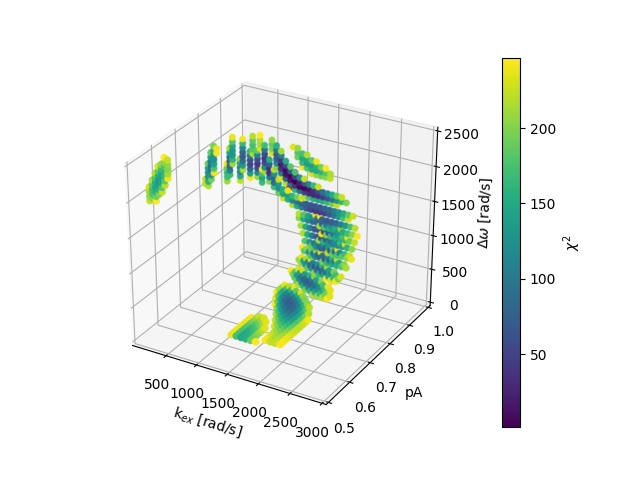

In [20]:
#  Convert
xs_sel = np.asarray(xs)
ys_sel = np.asarray(ys)
zs_sel = np.asarray(zs)
cs_sel = np.asarray(cs)
# Make filter for remove.
innermost = np.percentile(cs_sel, 1)
Nan_f = cs_sel > innermost
xs_sel[Nan_f] = np.nan
ys_sel[Nan_f] = np.nan
zs_sel[Nan_f] = np.nan
cs_sel[Nan_f] = np.nan

# Create figure
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot
ax.scatter(kex_c, pA_c, dw_rad_c_1, c="r", marker="^", s=200)
p = ax.scatter(xs_sel, ys_sel, zs_sel, c=cs_sel)
fig.colorbar(p, label="$\chi^2$")

ax.set_xlabel('k$_{ex}$ [rad/s]')
ax.set_xlim(kex_range[0], kex_range[-1])

ax.set_ylabel('pA')
ax.set_ylim(pA_range[0], pA_range[-1])

ax.set_zlabel('$\Delta \omega$ [rad/s]')
ax.set_zlim(dw_rad_range[0], dw_rad_range[-1])

# Print vals
if False:
    mask = np.isnan(xs_sel)
    arr = zip(cs_sel[~mask], xs_sel[~mask], ys_sel[~mask], zs_sel[~mask])
    for i, l in enumerate(arr):
        print(l)


# References <a name="references"></a>

## Ipywidgets documentation

* [Using Interact](http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)
* [Widget List](http://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html)
* [How to 'Save Notebook Widget State' before exporting to online view.](http://ipywidgets.readthedocs.io/en/stable/embedding.html)
* [Matplotlib documentation on backend.]( https://matplotlib.org/faq/usage_faq.html#what-is-a-backend)
* [stackoverflow on updates a plot in a loop](https://stackoverflow.com/questions/34486642/what-is-the-currently-correct-way-to-dynamically-update-plots-in-jupyter-ipython)
* [Widget at plotting in matplotlib. Does not work as intended.](http://nbviewer.jupyter.org/github/jenshnielsen/netcdf-lesson/blob/master/Interactive%20plotting%20with%20nbagg.ipynb)


## Code reference in relax

* [The target function to prepare data](https://github.com/nmr-relax/relax/blob/master/target_functions/relax_disp.py)
* [The library function of CR72](https://github.com/nmr-relax/relax/blob/master/lib/dispersion/cr72.py)
* [The library function of 'NS CPMG 2-site expanded'](https://github.com/nmr-relax/relax/blob/master/lib/dispersion/ns_cpmg_2site_expanded.py)
* [The library function of B14](https://github.com/nmr-relax/relax/blob/master/lib/dispersion/b14.py)